In [ ]:
using OrderedCollections
using LinearAlgebra, Statistics
using PyCall
using Tweaks.Plot
plot = pyimport("latextools.plot")
latextools = pyimport("latextools")
;

In [2]:
function save_plot(name::String, ax::PyObject; latex_height::String=raw"0.6*\columnwidth",
                   two_col::Bool=false, col_width::String="3.42in",
                   line_width::String="7.04in")
    if two_col
        preview_width, final_width = line_width, raw"\linewidth"
    else
        preview_width, final_width = col_width, raw"\columnwidth"
    end
    preview_latex_height = replace(replace(latex_height,
        raw"\columnwidth"=>col_width), raw"\linewidth"=>line_width)
    fig = plot.PgfplotsFigure()
    fig.append_plot(ax)
    pdf_conf = latextools.DocumentConfig(
                "standalone",
                options=("tikz","border=30pt"),
                packages=[latextools.pkg.inputenc])
    ax.width = preview_width
    ax.height = preview_latex_height
    preview = fig.render(config=pdf_conf, height=400)
    ax.width = final_width
    ax.height = latex_height
    fig.separate_file(name).save_tex("../toffoli-figs/")
    #preview  # PDF preview
    preview.rasterize(scale=2)  # Raster preview
end

save_plot (generic function with 1 method)

In [3]:
colors4 = [
    "black",
    "{rgb,190:red,72;green,132;blue,189}",
    "{rgb,190:red,112;green,169;blue,45}",
    "{rgb,190:red,180;green,56;blue,101}",
]
colors2 = [
    "{rgb,190:red,180;green,56;blue,101}",
    "{rgb,330:red,180;green,0;blue,60}",
]
;

In [4]:
lines = open("raw-johannesburg-counts.data") do f
    Iterators.Stateful(split(String(read(f)), '\n'))
end
group_data = OrderedDict{String, OrderedDict{NTuple{3, Int}, Any}}(
    "Qiskit,Norm" => OrderedDict(),
    "Qiskit,Craig" => OrderedDict(),
    "PreSwap,Norm" => OrderedDict(),
    "PreSwap,Craig" => OrderedDict(),
)
for line in lines
    (line == "" && length(lines) == 0) && break
    qubits = (parse.(Int, split(line, ',')[1:3])...,)
    line = popfirst!(lines)
    dist = parse(Int, line)
    for _ in 1:4
        comp_type = popfirst!(lines)
        num_gate2 = parse(Int, popfirst!(lines))
        success = nothing
        for (_, line) in zip(1:8, lines)
            if endswith(split(line, ',')[1], "000111")
                success = parse(Int, split(line, ',')[2]) / 2^13
            end
        end
        group_data[comp_type][qubits] = (dist=dist, num_gate2=num_gate2, success=success)
    end
end
for dict in values(group_data)
    sort!(dict, by=k->(-dict[k].dist, k))
end

In [5]:
# Geometric means
Dict(
    #k=>MathConstants.e^mean(log.([v.success for v in values(data)]))
    k=>mean([v.success for v in values(data)])
    for (k, data) in group_data
)

Dict{String,Float64} with 4 entries:
  "PreSwap,Norm"  => 0.482508
  "PreSwap,Craig" => 0.509644
  "Qiskit,Norm"   => 0.421083
  "Qiskit,Craig"  => 0.374503

In [6]:
# Geometric means
mean([(1-(log(v2.success)-log(v1.success)) / log(v1.success))
    for (v1, v2) in zip(values(group_data["Qiskit,Norm"]),
                        values(group_data["PreSwap,Craig"]))])

1.189703522724857

In [7]:
using Printf
for (k, v) in group_data["Qiskit,Norm"]
    @printf("    %-13s  # %s\n", "$k,", v)
end

    (6, 17, 3),    # (dist = 10, num_gate2 = 37, success = 0.2813720703125)
    (16, 1, 8),    # (dist = 10, num_gate2 = 54, success = 0.1943359375)
    (7, 18, 3),    # (dist = 9, num_gate2 = 24, success = 0.4942626953125)
    (17, 4, 11),   # (dist = 9, num_gate2 = 45, success = 0.29345703125)
    (19, 2, 6),    # (dist = 9, num_gate2 = 54, success = 0.2926025390625)
    (1, 19, 8),    # (dist = 8, num_gate2 = 30, success = 0.334716796875)
    (3, 15, 7),    # (dist = 8, num_gate2 = 40, success = 0.2545166015625)
    (3, 15, 13),   # (dist = 8, num_gate2 = 42, success = 0.369873046875)
    (3, 15, 14),   # (dist = 8, num_gate2 = 40, success = 0.3291015625)
    (3, 17, 5),    # (dist = 8, num_gate2 = 39, success = 0.4058837890625)
    (4, 5, 16),    # (dist = 8, num_gate2 = 46, success = 0.28125)
    (6, 4, 16),    # (dist = 8, num_gate2 = 42, success = 0.33154296875)
    (7, 3, 19),    # (dist = 8, num_gate2 = 21, success = 0.5450439453125)
    (9, 15, 2),    # (dist = 8, num_gate2 =

Geo mean: 0.4088172304790279


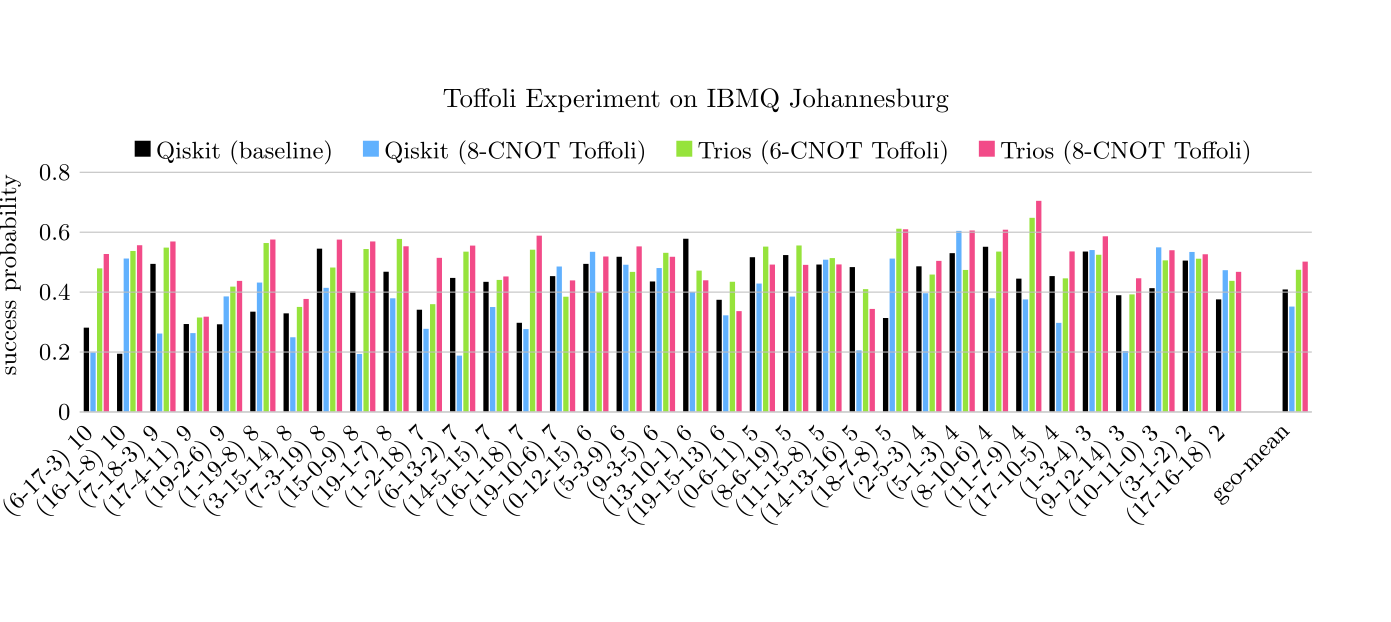

Geo mean: 0.35173713914801175
Geo mean: 0.47450881060592054
Geo mean: 0.5017832670104678


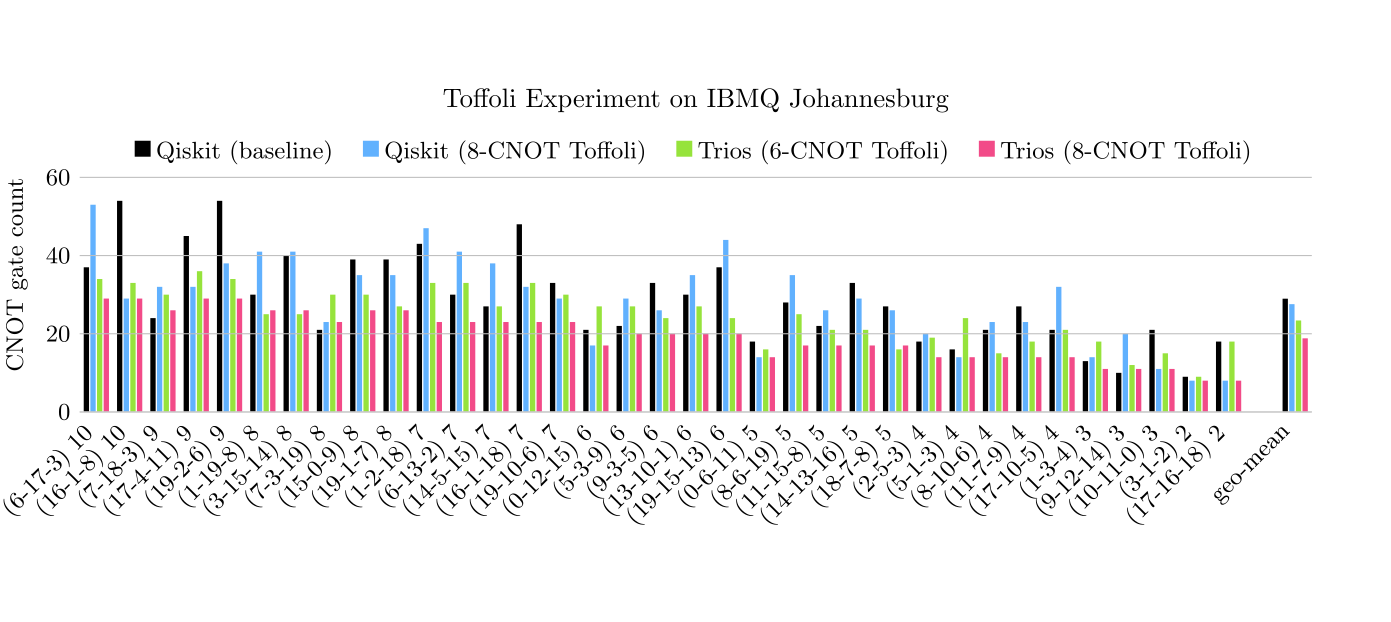

Geo mean: 28.965511018659207
Geo mean: 27.571546147540772
Geo mean: 23.39548267542428
Geo mean: 18.824704952412723


In [8]:
qubit_groups = [
    k for (i, k) in enumerate(keys(first(values(group_data))))
      if mod(i, 4) == 1
]
# Randomly select subsets representing every distance
qubit_groups = [
    (6, 17, 3),    # (dist = 10, num_gate2 = 37, success = 0.2813720703125)
    (16, 1, 8),    # (dist = 10, num_gate2 = 54, success = 0.1943359375)
    (7, 18, 3),    # (dist = 9, num_gate2 = 24, success = 0.4942626953125)
    (17, 4, 11),   # (dist = 9, num_gate2 = 45, success = 0.29345703125)
    (19, 2, 6),    # (dist = 9, num_gate2 = 54, success = 0.2926025390625)
    (1, 19, 8),    # (dist = 8, num_gate2 = 30, success = 0.334716796875)
#    (3, 15, 7),    # (dist = 8, num_gate2 = 40, success = 0.2545166015625)
#    (3, 15, 13),   # (dist = 8, num_gate2 = 42, success = 0.369873046875)
    (3, 15, 14),   # (dist = 8, num_gate2 = 40, success = 0.3291015625)
#    (3, 17, 5),    # (dist = 8, num_gate2 = 39, success = 0.4058837890625)
#    (4, 5, 16),    # (dist = 8, num_gate2 = 46, success = 0.28125)
#    (6, 4, 16),    # (dist = 8, num_gate2 = 42, success = 0.33154296875)
    (7, 3, 19),    # (dist = 8, num_gate2 = 21, success = 0.5450439453125)
#    (9, 15, 2),    # (dist = 8, num_gate2 = 39, success = 0.453369140625)
#    (10, 14, 2),   # (dist = 8, num_gate2 = 43, success = 0.3577880859375)
#    (12, 2, 19),   # (dist = 8, num_gate2 = 34, success = 0.45703125)
    (15, 0, 9),    # (dist = 8, num_gate2 = 39, success = 0.4017333984375)
#    (15, 3, 14),   # (dist = 8, num_gate2 = 37, success = 0.4119873046875)
#    (15, 9, 2),    # (dist = 8, num_gate2 = 40, success = 0.351318359375)
#    (15, 11, 3),   # (dist = 8, num_gate2 = 30, success = 0.421142578125)
    (19, 1, 7),    # (dist = 8, num_gate2 = 39, success = 0.468017578125)
    (1, 2, 18),    # (dist = 7, num_gate2 = 43, success = 0.3411865234375)
#    (2, 5, 13),    # (dist = 7, num_gate2 = 34, success = 0.37841796875)
#    (2, 17, 9),    # (dist = 7, num_gate2 = 37, success = 0.2603759765625)
#    (4, 2, 17),    # (dist = 7, num_gate2 = 51, success = 0.393798828125)
    (6, 13, 2),    # (dist = 7, num_gate2 = 30, success = 0.4473876953125)
#    (8, 11, 1),    # (dist = 7, num_gate2 = 30, success = 0.5595703125)
#    (10, 3, 9),    # (dist = 7, num_gate2 = 36, success = 0.265380859375)
#    (10, 8, 3),    # (dist = 7, num_gate2 = 37, success = 0.4345703125)
#    (13, 11, 2),   # (dist = 7, num_gate2 = 36, success = 0.342041015625)
    (14, 5, 15),   # (dist = 7, num_gate2 = 27, success = 0.434326171875)
#    (15, 0, 19),   # (dist = 7, num_gate2 = 57, success = 0.2520751953125)
#    (15, 4, 11),   # (dist = 7, num_gate2 = 40, success = 0.404541015625)
#    (15, 19, 6),   # (dist = 7, num_gate2 = 43, success = 0.42919921875)
    (16, 1, 18),   # (dist = 7, num_gate2 = 48, success = 0.297607421875)
#    (16, 6, 1),    # (dist = 7, num_gate2 = 24, success = 0.5015869140625)
#    (18, 0, 1),    # (dist = 7, num_gate2 = 39, success = 0.3736572265625)
#    (19, 1, 0),    # (dist = 7, num_gate2 = 45, success = 0.3170166015625)
    (19, 10, 6),   # (dist = 7, num_gate2 = 33, success = 0.453369140625)
    (0, 12, 15),   # (dist = 6, num_gate2 = 21, success = 0.4942626953125)
#    (1, 15, 11),   # (dist = 6, num_gate2 = 22, success = 0.4722900390625)
#    (3, 13, 8),    # (dist = 6, num_gate2 = 25, success = 0.3895263671875)
#    (3, 13, 11),   # (dist = 6, num_gate2 = 39, success = 0.2744140625)
#    (5, 1, 9),     # (dist = 6, num_gate2 = 28, success = 0.46240234375)
    (5, 3, 9),     # (dist = 6, num_gate2 = 22, success = 0.5179443359375)
#    (5, 3, 11),    # (dist = 6, num_gate2 = 37, success = 0.5155029296875)
#    (5, 7, 3),     # (dist = 6, num_gate2 = 25, success = 0.5579833984375)
#    (5, 12, 9),    # (dist = 6, num_gate2 = 30, success = 0.3607177734375)
#    (5, 18, 19),   # (dist = 6, num_gate2 = 40, success = 0.2034912109375)
    (9, 3, 5),     # (dist = 6, num_gate2 = 33, success = 0.435546875)
#    (12, 10, 2),   # (dist = 6, num_gate2 = 33, success = 0.5711669921875)
#    (12, 14, 2),   # (dist = 6, num_gate2 = 33, success = 0.389892578125)
#    (13, 7, 15),   # (dist = 6, num_gate2 = 22, success = 0.5284423828125)
#    (13, 8, 18),   # (dist = 6, num_gate2 = 18, success = 0.37451171875)
    (13, 10, 1),   # (dist = 6, num_gate2 = 30, success = 0.578125)
#    (13, 18, 10),  # (dist = 6, num_gate2 = 36, success = 0.2967529296875)
#    (14, 2, 12),   # (dist = 6, num_gate2 = 45, success = 0.3619384765625)
#    (18, 5, 6),    # (dist = 6, num_gate2 = 40, success = 0.4544677734375)
#    (18, 13, 6),   # (dist = 6, num_gate2 = 36, success = 0.354248046875)
    (19, 15, 13),  # (dist = 6, num_gate2 = 37, success = 0.3743896484375)
    (0, 6, 11),    # (dist = 5, num_gate2 = 18, success = 0.5164794921875)
#    (0, 15, 2),    # (dist = 5, num_gate2 = 21, success = 0.5870361328125)
#    (5, 11, 2),    # (dist = 5, num_gate2 = 27, success = 0.40380859375)
#    (6, 8, 15),    # (dist = 5, num_gate2 = 24, success = 0.5335693359375)
#    (7, 6, 16),    # (dist = 5, num_gate2 = 27, success = 0.4759521484375)
    (8, 6, 19),    # (dist = 5, num_gate2 = 28, success = 0.523681640625)
#    (9, 13, 2),    # (dist = 5, num_gate2 = 24, success = 0.4010009765625)
#    (10, 12, 17),  # (dist = 5, num_gate2 = 40, success = 0.2967529296875)
#    (11, 2, 5),    # (dist = 5, num_gate2 = 27, success = 0.4833984375)
#    (11, 13, 16),  # (dist = 5, num_gate2 = 43, success = 0.3160400390625)
    (11, 15, 8),   # (dist = 5, num_gate2 = 22, success = 0.4920654296875)
#    (12, 3, 14),   # (dist = 5, num_gate2 = 27, success = 0.4979248046875)
#    (12, 10, 9),   # (dist = 5, num_gate2 = 24, success = 0.50146484375)
#    (13, 10, 7),   # (dist = 5, num_gate2 = 30, success = 0.461181640625)
#    (13, 11, 16),  # (dist = 5, num_gate2 = 30, success = 0.427490234375)
    (14, 13, 16),  # (dist = 5, num_gate2 = 33, success = 0.4835205078125)
#    (16, 10, 1),   # (dist = 5, num_gate2 = 33, success = 0.4075927734375)
#    (17, 12, 18),  # (dist = 5, num_gate2 = 27, success = 0.3048095703125)
#    (18, 4, 17),   # (dist = 5, num_gate2 = 24, success = 0.406005859375)
    (18, 7, 8),    # (dist = 5, num_gate2 = 27, success = 0.3135986328125)
    (2, 5, 3),     # (dist = 4, num_gate2 = 18, success = 0.486083984375)
#    (4, 9, 1),     # (dist = 4, num_gate2 = 24, success = 0.426025390625)
    (5, 1, 3),     # (dist = 4, num_gate2 = 16, success = 0.530029296875)
#    (7, 15, 5),    # (dist = 4, num_gate2 = 18, success = 0.581298828125)
    (8, 10, 6),    # (dist = 4, num_gate2 = 21, success = 0.5513916015625)
#    (9, 17, 19),   # (dist = 4, num_gate2 = 15, success = 0.4993896484375)
    (11, 7, 9),    # (dist = 4, num_gate2 = 27, success = 0.4449462890625)
#    (11, 10, 8),   # (dist = 4, num_gate2 = 28, success = 0.458251953125)
#    (12, 16, 11),  # (dist = 4, num_gate2 = 21, success = 0.5123291015625)
#    (13, 7, 9),    # (dist = 4, num_gate2 = 18, success = 0.32080078125)
    (17, 10, 5),   # (dist = 4, num_gate2 = 21, success = 0.4534912109375)
    (1, 3, 4),     # (dist = 3, num_gate2 = 13, success = 0.535400390625)
#    (6, 1, 0),     # (dist = 3, num_gate2 = 15, success = 0.697265625)
    (9, 12, 14),   # (dist = 3, num_gate2 = 10, success = 0.3896484375)
#    (10, 5, 16),   # (dist = 3, num_gate2 = 22, success = 0.3924560546875)
    (10, 11, 0),   # (dist = 3, num_gate2 = 21, success = 0.4132080078125)
    (3, 1, 2),     # (dist = 2, num_gate2 = 9, success = 0.5052490234375)
#    (7, 5, 6),     # (dist = 2, num_gate2 = 9, success = 0.6964111328125)
    (17, 16, 18),  # (dist = 2, num_gate2 = 18, success = 0.375732421875)
]
#qubit_groups = NTuple{3, Int}[]
#for dist in reverse(2:10)
#    matches = [k for (k, v) in first(values(group_data)) if v.dist==dist]
#    qubit_groups
#end

for comp_gates in [false, true]
    ax = plot.BarPlot("Toffoli Experiment on IBMQ Johannesburg",
                      ylabel=comp_gates ? "CNOT gate count" : "success probability",
                      #xlabel="(qubit triplet) total distance",
                      bar_width="2pt", bar_space="0.5pt", ygrid=true,
                      rotate_labels=true)
    make_bar_plot(
        [["($(q[1])-$(q[2])-$(q[3])) $(first(values(group_data))[q].dist)"=>q
         for q in qubit_groups];
            "gap"=>(-1,-1,-1); "geo-mean"=>(0,0,0)],
        [   "Qiskit (baseline)"=>group_data["Qiskit,Norm"],
            "Qiskit (8-CNOT Toffoli)"=>group_data["Qiskit,Craig"],
            "Trios (6-CNOT Toffoli)"=>group_data["PreSwap,Norm"],
            "Trios (8-CNOT Toffoli)"=>group_data["PreSwap,Craig"]],
        label_rotation=30, label_anchor="right",
        colors=colors4,
        ax=ax,
    ) do qubits, data
        qubits == (-1, -1, -1) && return NaN
        if qubits == (0, 0, 0)
            if comp_gates
                vals = [v.num_gate2 for v in values(data)]
            else
                vals = [v.success for v in values(data)]
            end
            v = 10^mean(log10.(vals))
            println("Geo mean: $v")
            return v
        end
        comp_gates ? data[qubits].num_gate2 : data[qubits].success
    end
    display(save_plot("ibm-toffoli-$(comp_gates ? "gates" : "success").tex",
                      ax, two_col=true))
end

v: 286.36934673366835
Geo-mean: 122.74024419726825
v: 286.36934673366835
Geo-mean: 122.74024419726825


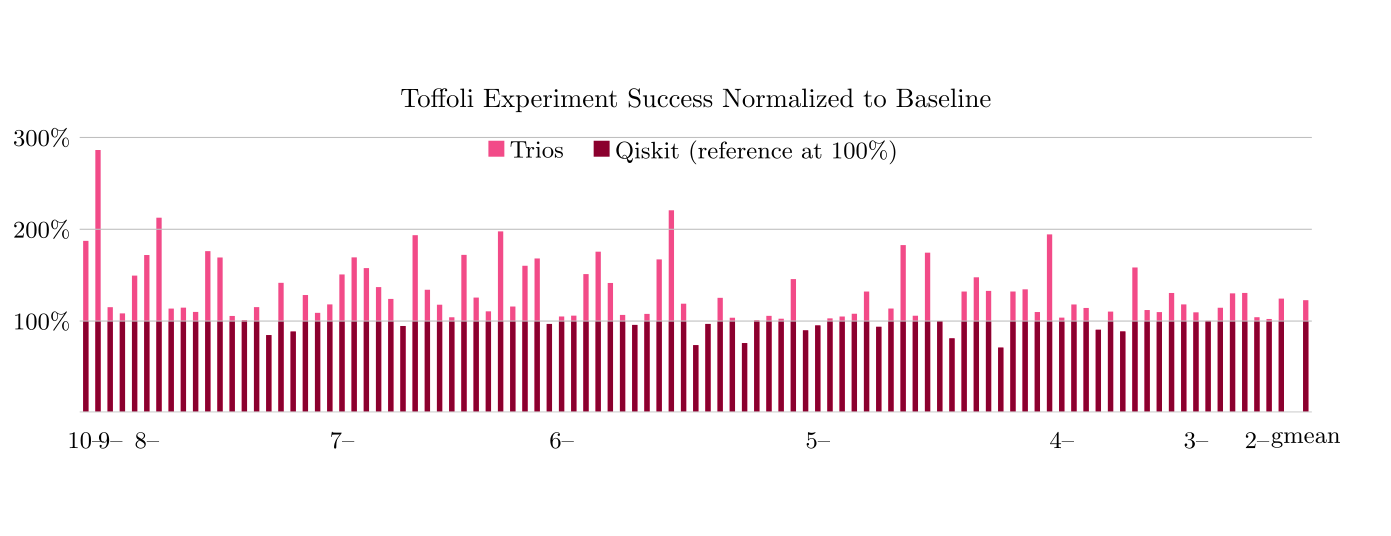

In [9]:
#qubit_groups = [
#    k for (i, k) in enumerate(keys(first(values(group_data))))
#      if mod(i, 4) == 1
#]

ax = plot.BarPlot("Toffoli Experiment Success Normalized to Baseline",
                  #ylabel=raw"Normalized Success [$1-(\log(p)-\log(p_{base}))/\log(p_{base})$]",
                  #ylabel=raw"\% reduction in circuit execution errors",
                  #xlabel=raw"Random choices of three qubits, sorted by total distance",
                  bar_width="2pt", bar_space="-2pt", ymax=300, log=false,
                  ygrid=true,
                  #width=raw"\linewidth",
                  width=raw"6.5in",
                  y_tick_suffix=raw"\%",
                  rotate_labels=0,
                  extra_config=raw"ymin=1, ylabel=$p_{trios}/p_{baseline}$")
last_dist = -1
counter = 0
make_bar_plot(
    [[begin #"($(q[1])-$(q[2])-$(q[3])) $(first(values(group_data))[q].dist)"=>q
         global last_dist, counter
         if first(values(group_data))[q].dist==last_dist
            counter += 1
            repeat("\U00A0", i)
         else
            last_dist = first(values(group_data))[q].dist
            counter = 0
            "$(first(values(group_data))[q].dist)--"
         end=>q
     end
     for (i, q) in
            #qubit_groups
            enumerate(keys(first(values(group_data))))
    ]; "gap"=>(-1,-1,-1); "gmean"=>(0,0,0)],
    ["Trios"=>(false, group_data["PreSwap,Craig"]),
     "Qiskit (reference at 100\\%)"=>(true, group_data["PreSwap,Craig"])],  # Overlay for <100%
    label_rotation=30, label_anchor="right",
    colors=colors2,
    ax=ax,
) do qubits, (is_overlay, data)
    qubits == (-1, -1, -1) && return NaN
    if qubits == (0, 0, 0)
        vals = [v.success for v in values(data)]
        bench_vals = [v.success for v in values(group_data["Qiskit,Norm"])]
        mean1 = 10^mean(log10.(vals))
        bench_mean = 10^mean(log10.(bench_vals))
        v = mean1 / bench_mean * 100
        println("Geo-mean: $v")
        return is_overlay ? min(v, 100) : v
    end
    #log(data[qubits].success) / log(group_data["Qiskit,Norm"][qubits].success)
    #v = (1-(log(data[qubits].success)-log(group_data["Qiskit,Norm"][qubits].success)
    #) / log(group_data["Qiskit,Norm"][qubits].success)) * 100
    
    v = data[qubits].success / group_data["Qiskit,Norm"][qubits].success * 100
    if v > 250
        println("v: $v")
            end
    #data[qubits].num_gate2 / group_data["Qiskit,Norm"][qubits].num_gate2
    is_overlay ? min(v, 100) : v
end
save_plot("ibm-toffoli-success-norm.tex",
          ax, two_col=true)

In [10]:
latextools.render_snippet(raw"5\%$\rightarrow$6\%")

PyObject <latextools.pdf.Pdf object at 0x167e40e50>